# 11. Annex 4: Principal Component Analysis

## 11.1 Set environment
We load the decomposition module from sklearn. We also import pickle as we will use it to save the PCA components.

In [1]:
import numpy as np
from sklearn import decomposition
import pickle as pk
# Set location of data file
file="data/era20c.npy"
data = np.load(file)
data = data.reshape(data.shape[0], data.shape[1]*data.shape[2]*data.shape[3])

## 11.2 Principle Component Analysis
We start with setting the number of components to 4096, so we can check how much variance the first n componets are accountable for. We want to test the same compression factor as the autoencoder, so we will use 32 components.

In [2]:
pca = decomposition.PCA(n_components=32)
pca.fit(data)

PCA(n_components=32)

How much variance are these accountable for?

In [3]:
pca.explained_variance_ratio_.sum()

0.9649564068359819

Save the PCA components.

In [4]:
with open('data/pca.pkl', 'wb') as pickle_file:
    pk.dump(pca, pickle_file)

## 11.3 Feature reduction using PCA
Let's reduce our section of the ERA-20C dataset.

In [5]:
with open('data/pca.pkl', 'rb') as pickle_file:
    pca = pk.load(pickle_file)
data_reduced = pca.transform(data) 
np.save("data/era20c_pca.npy", data_reduced)

## 11.4 Search with the PCA reduced dataset

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from isoplot import isoplot

# load data
era20c = np.load("data/era20c.npy")
compressed = np.load("data/era20c_pca.npy")
dates = np.load("data/dates.npy")
scale = np.load("data/scale.npy")
zone = np.load("data/zone.npy")
msl = np.load("data/msl.npy")
z500 = np.load("data/z500.npy")

# reshaping 2 spatial dimensions to 1, to be able to use the numpy norm
shape1 = era20c.shape[1]
shape2 = era20c.shape[2]
grid_points = shape1 * shape2
grid_sqrt = np.sqrt(grid_points) 
era20c = era20c.reshape(era20c.shape[0],grid_points,era20c.shape[3])

In [7]:
# set the reference date here
date = "1990 1 25"
#date = "1953 1 31"
#date = "1976 1 2"
#date = "1976 8 1"
#date = "2003 8 10"

# corresponding reference data
date_index = np.where(dates == date)
compressed_ref = compressed[date_index]
era20c_ref = era20c[date_index]
msl_ref = msl[date_index]
z500_ref = z500[date_index]

# initialize arrays
compressed_dist = np.zeros(dates.shape[0])
msl_dist = np.zeros(dates.shape[0])
z500_dist = np.zeros(dates.shape[0])
era20c_dist = np.zeros(dates.shape[0])

# calculate distances
for i in range(dates.shape[0]):
    compressed_dist[i] = np.linalg.norm(compressed[i]-compressed_ref)
    era20c_dist[i] = np.linalg.norm(era20c[i]-era20c_ref)
    msl_dist[i] = np.linalg.norm(msl[i]-msl_ref) / grid_sqrt
    z500_dist[i] = np.linalg.norm(z500[i]-z500_ref) / grid_sqrt

# smallest distances
smallest_compressed = np.argsort(compressed_dist)[:25]
print("Index\tDate\t\tCompr.Dist.\tUncompr.Dist.\tMSL Dist.[Pa]\tZ500 Dist.[m**2/s**2]")
for i in smallest_compressed:
    print("%d\t%s\t%.3f\t\t%.3f\t\t%.0f\t\t%.0f" % (i,dates[i],compressed_dist[i],era20c_dist[i],msl_dist[i],z500_dist[i]))

Index	Date		Compr.Dist.	Uncompr.Dist.	MSL Dist.[Pa]	Z500 Dist.[m**2/s**2]
32896	1990 1 25	0.000		0.000		0		0
23757	1965 1 17	2.596		3.086		715		604
36154	1998 12 27	2.831		3.307		732		699
32142	1988 1 2	2.942		3.450		802		672
33239	1991 1 3	2.960		3.445		738		760
31493	1986 3 24	3.023		3.340		691		768
32180	1988 2 9	3.125		3.664		852		713
32913	1990 2 11	3.186		3.791		796		857
32897	1990 1 26	3.205		3.571		851		661
30693	1984 1 14	3.407		3.731		771		859
36174	1999 1 16	3.436		3.807		799		862
31432	1986 1 22	3.460		3.826		778		895
3301	1909 1 15	3.579		3.959		870		845
22252	1960 12 4	3.589		3.930		814		902
33241	1991 1 5	3.656		4.024		853		901
20801	1956 12 14	3.692		4.050		886		870
24912	1968 3 17	3.705		4.196		944		865
8086	1922 2 21	3.713		3.985		1015		610
32895	1990 1 24	3.721		4.062		878		886
33939	1992 12 3	3.737		4.093		905		866
3300	1909 1 14	3.753		4.141		913		880
4325	1911 11 5	3.797		4.111		686		1110
5889	1916 2 16	3.840		4.169		929		873
39056	2006 12 7	3.856		4.181		806		102

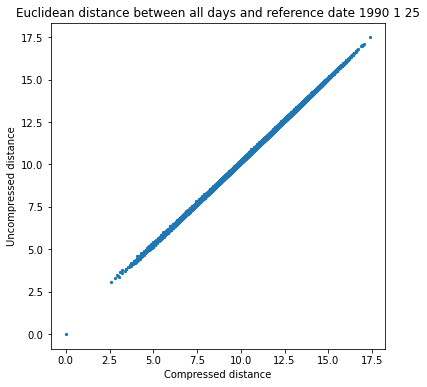

Pearson correlation coefficient: 1.000


In [8]:
plt.rcParams["figure.figsize"] = (6,6)
plt.scatter(compressed_dist, era20c_dist, s=5)
plt.ylabel("Uncompressed distance")
plt.xlabel("Compressed distance")
plt.title("Euclidean distance between all days and reference date " + date)
plt.show()
print("Pearson correlation coefficient: %.3f" % np.corrcoef(compressed_dist,era20c_dist)[0,1])

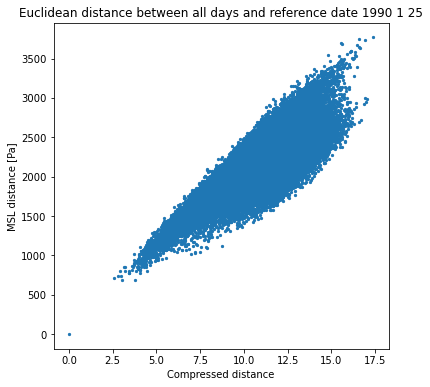

Pearson correlation coefficient: 0.787


In [9]:
plt.rcParams["figure.figsize"] = (6,6)
plt.scatter(compressed_dist, msl_dist, s=5)
plt.ylabel("MSL distance [Pa]")
plt.xlabel("Compressed distance")
plt.title("Euclidean distance between all days and reference date " + date)
plt.show()
print("Pearson correlation coefficient: %.3f" % np.corrcoef(compressed_dist,msl_dist)[0,1])

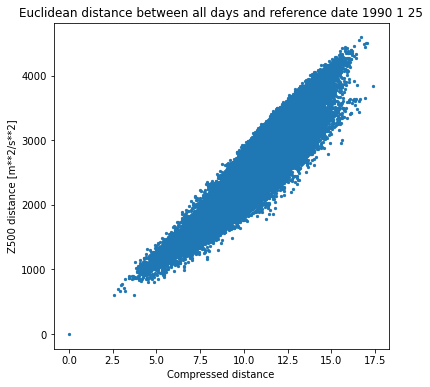

Pearson correlation coefficient: 0.931


In [10]:
plt.rcParams["figure.figsize"] = (6,6)
plt.scatter(compressed_dist, z500_dist, s=5)
plt.ylabel("Z500 distance [m**2/s**2]")
plt.xlabel("Compressed distance")
plt.title("Euclidean distance between all days and reference date " + date)
plt.show()
print("Pearson correlation coefficient: %.3f" % np.corrcoef(compressed_dist,z500_dist)[0,1])

## 4.6 Mean Correlation between distances
Again, we will calculate the correlations for sample of 100 random days.

In [11]:
sample_size = 100
rand_indices = np.random.randint(era20c.shape[0],size=sample_size)
corr =  np.zeros(sample_size)
corr_msl =  np.zeros(sample_size)
corr_z500 =  np.zeros(sample_size)
for i in range(sample_size):
    date_index = rand_indices[i]
    compressed_ref = compressed[date_index]
    era20c_ref = era20c[date_index]
    msl_ref = msl[date_index]
    z500_ref = z500[date_index]

    # initialize arrays
    compressed_dist = np.zeros(dates.shape[0])
    msl_dist = np.zeros(dates.shape[0])
    z500_dist = np.zeros(dates.shape[0])
    era20c_dist = np.zeros(dates.shape[0])

    # calculate distances
    for j in range(dates.shape[0]):
        compressed_dist[j] = np.linalg.norm(compressed[j]-compressed_ref)
        era20c_dist[j] = np.linalg.norm(era20c[j]-era20c_ref)
        msl_dist[j] = np.linalg.norm(msl[j]-msl_ref) / grid_sqrt
        z500_dist[j] = np.linalg.norm(z500[j]-z500_ref) / grid_sqrt
        
    # calculate correlation coefficients
    corr[i] = np.corrcoef(compressed_dist,era20c_dist)[0,1]
    corr_msl[i] = np.corrcoef(compressed_dist,msl_dist)[0,1]
    corr_z500[i] = np.corrcoef(compressed_dist,z500_dist)[0,1]

In [12]:
import pandas as pd
pd.options.display.float_format = '{:.3f}'.format
pd_corr = pd.DataFrame(corr, columns=['corr'])
pd_corr['corr_msl'] = pd.DataFrame(corr_msl, columns=['corr'])
pd_corr['corr_z500'] = pd.DataFrame(corr_z500, columns=['corr'])
pd_corr.describe()

,corr,corr_msl,corr_z500
count,100.000,100.000,100.000
mean,1.000,0.744,0.934
std,0.000,0.170,0.053
min,0.999,0.182,0.755
25%,1.000,0.623,0.906
50%,1.000,0.817,0.940
75%,1.000,0.882,0.981
max,1.000,0.939,0.991


In [13]:
pd_corr.std()/np.sqrt(sample_size) 

corr        0.000
corr_msl    0.017
corr_z500   0.005
dtype: float64